# Sentiment Analysis Methods: 
Methods for cleaning the text of a tweet, tokenizing it, tagging it, lemmatizing it, and finally summing the scores. 

Credit goes to Natural Language Toolkit for creating such a comprehensive utility for handling these operations. Further credit goes to Natural Language Processing for Hackers ( nlpforhackers.io ) for excellent tutorials and for providing a significant portion of the swn_polarity method

In [144]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

# remove any problematic, remaining html chars
def clean_text(text):
    text = text.replace("<br />", " ")
    return text
 
# returns a positive (1) or negative (0) sentiment
def swn_polarity(text):
    # NLTK Lemmatizer utility
    lemmatizer = WordNetLemmatizer()
    
    sentiment = 0.0
    tokens_count = 0
    text = clean_text(text)
    raw_sentences = sent_tokenize(text)
    
    for raw_sentence in raw_sentences:
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))
 
        for word, tag in tagged_sentence:
        
            
            # convert from NLTK to WordNet tagging
            if tag.startswith('J'):
                wn_tag = wn.ADJ
            elif tag.startswith('N'):
                wn_tag =  wn.NOUN
            elif tag.startswith('R'):
                wn_tag =  wn.ADV
            elif tag.startswith('V'):
                wn_tag =  wn.VERB
            else :
                wn_tag = None
            
            
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
 
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
 
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
 
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
 
            sentiment += swn_synset.pos_score() - swn_synset.neg_score()
            tokens_count += 1
 
    # default to positive
    if not tokens_count:
        return 1
 
    # return positive or negative sentiment for this tweet
    if sentiment >= 0:
        return 1
 
    return 0

# Import XML files and calculate weighted sentiment scores

Each file represents all of the mined twitter data for a given movie
files are named after the term used for their respective searches

films to be searched as well as their rotten tomato critic and audience scores are outlined in the file movie_ratings.csv

In [145]:
import xml.etree.ElementTree as et 
import numpy as np
import pandas as pd
movie_results = pd.DataFrame()

# import list of movies to analyze
# based on items in this list, xml files for each move will be imported next
movie_ratings = pd.read_csv("movie_ratings.csv") 

print("beginning analysis")

for index, row in movie_ratings.iterrows():
    
    # import xml
    filename = "data/" + row['term'] + ".xml"
    xtree = et.parse(filename)
    xroot = xtree.getroot() 
    df_cols = ["id", "followers", "likes", "retweets", "text"]
    rows = []

    for node in xroot: 
        s_id = node.find("id").text
        s_followers = node.find("followers").text
        s_likes = node.find("likes").text
        s_retweets = node.find("retweets").text
        s_text = node.find("text").text

        rows.append({"id": s_id, "followers": s_followers, "likes": s_likes, "retweets": s_retweets, "text": s_text, })

    data = pd.DataFrame(rows, columns = df_cols)
    
    n = 0
    total = 0
    total_uw = 0
    for index, row2 in data.iterrows():
        
        # to test on shorter runs, uncomment 2 lines below
#         if(n > 10):
#             break
            
        followers = float(row2['followers'])
        likes = float(row2['likes'])
        retweets = float(row2['retweets'])
        
        #get initial score
        score = swn_polarity(row2['text'])
        
        n += 1
        
        # calculate weighted score
        if(followers > 10 and likes > 10 and retweets > 10):
            val = np.log(followers + likes + retweets)*1.5
            n+=val
            total+=score*val
        else:
            total+=score
            
        # calculate unweighted score
        total_uw += score
        
    final_score = (total / n )*100
    final_uw_score = (total_uw / n )*100
    
    new_row = pd.Series([row['title'], row['critics'],  row['audience'], final_score, final_uw_score])
    row_df = pd.DataFrame([new_row])
    movie_results = pd.concat([row_df, movie_results], ignore_index=True)


print("analysis complete")

beginning analysis
analysis complete


# Calculate Performance

output scores for percent error and mean absolute error for
    * weighted score calculations
    * unweighted score calculations

In [146]:
n = 0
percent_error = 0
for index, row in movie_results.iterrows():
    n+=1
    a = row[2]
    o = row[3]
    pe = abs(a - o) / a * 100
    percent_error += pe
    
percent_error = percent_error / n
print("percent error, weighted:\t\t" + str(percent_error))

n = 0
percent_error = 0
for index, row in movie_results.iterrows():
    n+=1
    a = row[2]
    o = row[4]
    pe = abs(a - o) / a * 100
    percent_error += pe
    
percent_error = percent_error / n
print("percent error, unweighted:\t\t" + str(percent_error))

from sklearn.metrics import mean_absolute_error
y_true = movie_results.iloc[:,2]
y_pred = movie_results.iloc[:,3]
mae = mean_absolute_error(y_true, y_pred)
print("mean absolute error, weighted:\t\t" + str(mae))

y_true = movie_results.iloc[:,2]
y_pred = movie_results.iloc[:,4]
mae = mean_absolute_error(y_true, y_pred)
print("mean absolute error, unweighted:\t" + str(mae))

percent error, weighted:		15.696398741107233
percent error, unweighted:		19.68515768594175
mean absolute error, weighted:		12.592179192809699
mean absolute error, unweighted:	16.195961719265203


## Graphs and results table

* blue: Rotten Tomato Audience Score
* red: Predicted score (weighted)
* black: Predicted score (unweighted)

,Film,Critic Score,Audience Score,Prediction,Prediction (unweighted)
0,Trolls World Tour,70,62,50.473232,49.073742
1,The Last Full Measure,60,96,85.196591,70.727396
2,The Invisible Man,91,88,73.067383,73.067383
3,The Gentlemen,74,84,89.520786,82.339862
4,The Current War: Director's Cut,60,79,77.352674,63.174119
5,The Call of the Wild,62,89,68.604651,68.604651
6,The Banker,75,100,95.636231,87.804330
7,Spies in Disguise,75,92,89.936655,77.689023
8,Sonic the Hedgehog,64,93,73.741574,69.214719
9,Star Wars: The Rise of Skywalker,52,86,76.985685,73.645096


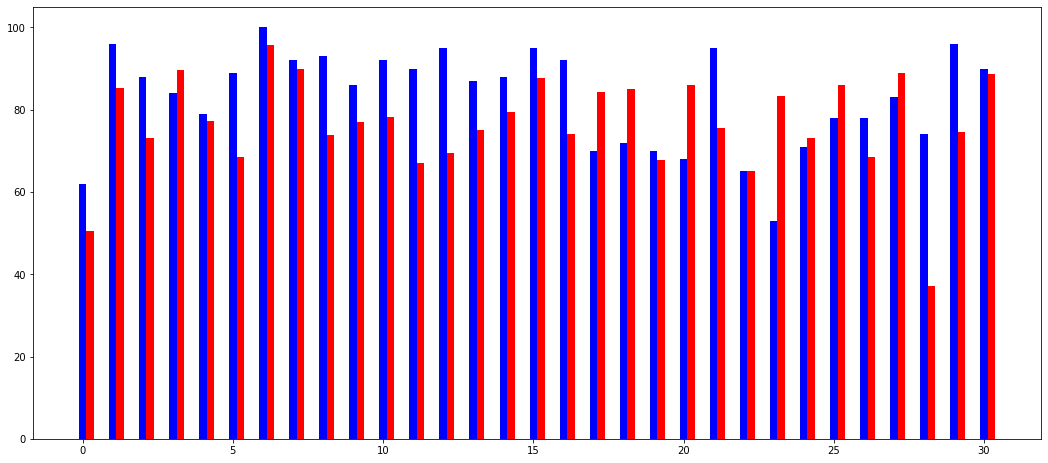

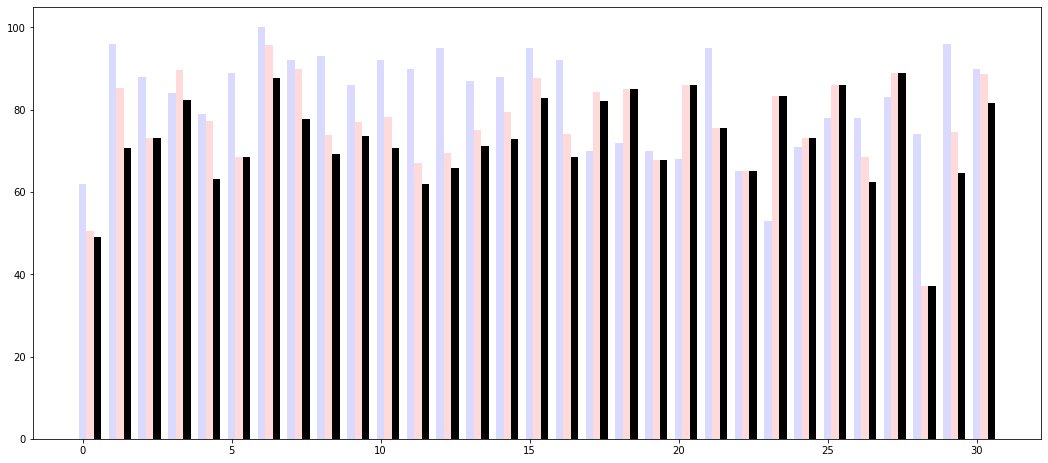

In [147]:
import matplotlib.pyplot as plt

movie_results.iloc[:,2]
X = np.arange(31)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, movie_results.iloc[:,2], color = 'b', width = 0.25)
ax.bar(X + 0.25, movie_results.iloc[:,3], color = 'r', width = 0.25)

X = np.arange(31)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, movie_results.iloc[:,2], color = '#0000ff25', width = 0.25)
ax.bar(X + 0.25, movie_results.iloc[:,3], color = '#ff000025', width = 0.25)
ax.bar(X + 0.50, movie_results.iloc[:,4], color = '#000000', width = 0.25)

movie_results.columns = ['Film', 'Critic Score', 'Audience Score', 'Prediction', 'Prediction (unweighted)']
movie_results